In [1]:
# Importing dependencies 
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Importing dependencies 
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Reviewing the Dataset

In [9]:
# Inspecting types of data
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#Print table results for station
for row in session.query(station.longitude, station.name, station.id, station.elevation, station.latitude, station.station).all():
    print(row)

(-157.8168, 'WAIKIKI 717.2, HI US', 1, 3.0, 21.2716, 'USC00519397')
(-157.8015, 'KANEOHE 838.1, HI US', 2, 14.6, 21.4234, 'USC00513117')
(-157.8374, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 3, 7.0, 21.5213, 'USC00514830')
(-157.9751, 'PEARL CITY, HI US', 4, 11.9, 21.3934, 'USC00517948')
(-158.0111, 'UPPER WAHIAWA 874.3, HI US', 5, 306.6, 21.4992, 'USC00518838')
(-157.71139, 'WAIMANALO EXPERIMENTAL FARM, HI US', 6, 19.5, 21.33556, 'USC00519523')
(-157.84888999999998, 'WAIHEE 837.5, HI US', 7, 32.9, 21.45167, 'USC00519281')
(-157.9992, 'HONOLULU OBSERVATORY 702.2, HI US', 8, 0.9, 21.3152, 'USC00511918')
(-157.8025, 'MANOA LYON ARBO 785.2, HI US', 9, 152.4, 21.3331, 'USC00516128')


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date[0]

'2017-08-23'

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
previous_year_data =session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= '2016-08-23').filter(measurement.date <= '2017-08-23').\
    order_by(measurement.date).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
precipitation_df = pd.DataFrame(previous_year_data, columns=['date', 'prcp']).sort_values(by ='date')
precipitation_df = pd.DataFrame(previous_year_data).rename(columns = {'prcp': 'precipitation'})

# Set the index to the date column
precipitation_df = precipitation_df.set_index('date')

# Display results
precipitation_df.head(10)

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


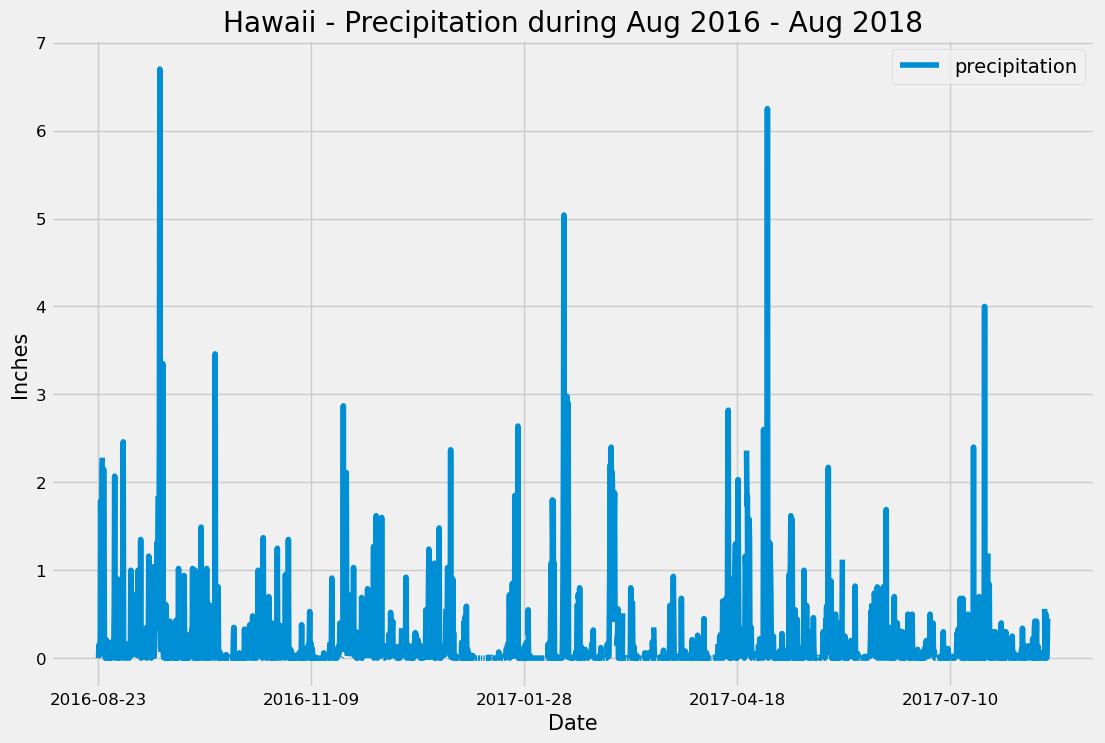

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot( 
    title=(f'Hawaii - Precipitation during Aug 2016 - Aug 2018'), figsize = (12,8),
    rot=0,
    fontsize=12,
    grid=True,
    )
plt.xlabel('Date', fontsize=15)
plt.ylabel('Inches', fontsize=15)

# Saving the output
plt.savefig(f'Precipitations_bar.png')
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Print the dicts to see the values
session.query(station).first().__dict__
session.query(measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2476fa1b6d0>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08}

In [16]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(station.id)).scalar()
print(f"Total number of stations is: {station_count}")

Total number of stations is: 9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station,
                    func.count(measurement.id)).group_by(measurement.station).order_by(func.count(measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
summary = [measurement.station, 
      func.min(measurement.tobs),
      func.max(measurement.tobs),
      func.avg(measurement.tobs)]
most_active = session.query(*summary).filter_by(station = "USC00519281").all()

print(f"The lowest temperature for station ID: {most_active[0][0]} is {most_active[0][1]}")
print(f"The highest temperature for station ID: {most_active[0][0]} is {most_active[0][2]}")
print(f"The average temperature for station ID: {most_active[0][0]} is {most_active[0][3]}")

The lowest temperature for station ID: USC00519281 is 54.0
The highest temperature for station ID: USC00519281 is 85.0
The average temperature for station ID: USC00519281 is 71.66378066378067


In [19]:
# Query the last 12 months of temperature observation data for the most active station
tobs_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= '2016-08-23').filter(measurement.date <= '2017-08-23').\
    order_by(measurement.date).all()

# Load the query results into a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'TOBS'])

# Display the df
tobs_df

,Date,TOBS
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


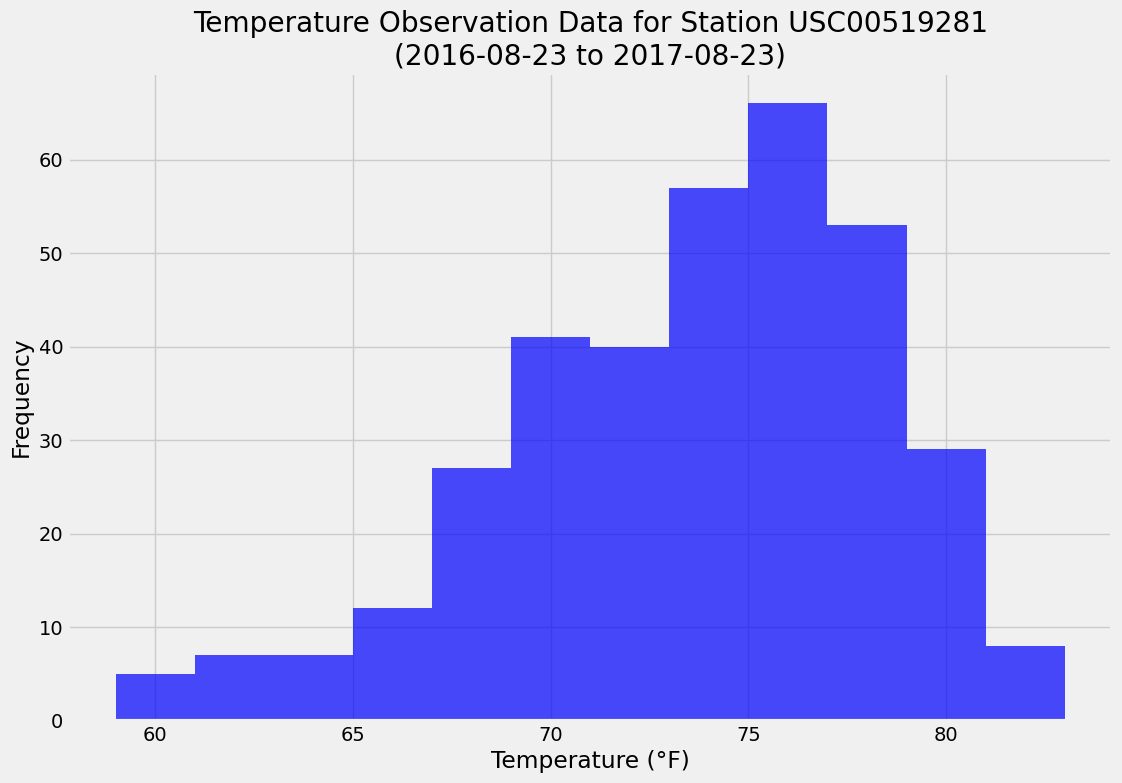

In [20]:
# Using the most active station id plot the results of the temp for the last 12 months as a histogram
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the histogram
plt.hist(tobs_df['TOBS'], bins=12, color='blue', alpha=0.7)

# Set labels and title
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for Station USC00519281\n(2016-08-23 to 2017-08-23)')

# Save the figure (if needed)
plt.savefig('TOBS_histogram.png')

# Display the histogram
plt.show()

# Close Session

In [21]:
# Close Session
session.close()